In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
data_dir = 'E:/Jupyter NB/10 class Classification/'

train_dir = 'E:/Jupyter NB/10 class Classification/Train_val_test/train'
val_dir = 'E:/Jupyter NB/10 class Classification/Train_val_test/val'

In [107]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import layers
from keras import models

from keras import optimizers

from image_preprocessing_ver2 import ImageDataGenerator

from keras.models import Model
from keras.layers import Lambda, concatenate, Activation
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras import backend as K

from keras.applications.mobilenet import preprocess_input
from mobilenet import get_mobilenet
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [108]:
train_logits = np.load(data_dir + 'train_logits.npy', allow_pickle = True)[()]
val_logits = np.load(data_dir + 'val_logits.npy', allow_pickle = True)[()]

In [109]:
data_generator = ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function=preprocess_input
)

# note: i'm also passing dicts of logits
train_generator = data_generator.flow_from_directory(
    train_dir, train_logits,
    target_size=(224, 224),
    batch_size=64
)

validation_generator = data_generator.flow_from_directory(
    val_dir, val_logits,
    target_size=(224, 224),
    batch_size=64
)

Found 2000 images belonging to 20 classes.
Found 400 images belonging to 20 classes.


In [110]:
'''
std_model = models.Sequential([
    layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (224,224,3)),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, (3,3), activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.4),
    layers.Dense(20, activation = 'softmax')
    
])
'''
std_model = get_mobilenet(224, alpha=0.25, weight_decay=1e-5, dropout=0.1)

std_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 93312)            

In [111]:
temperature = 5

# remove softmax
std_model.layers.pop()

# usual probabilities
logits = std_model.layers[-1].output
probabilities = Activation('softmax')(logits)

# softed probabilities
logits_T = Lambda(lambda x: x/temperature)(logits)
probabilities_T = Activation('softmax')(logits_T)

output = concatenate([probabilities, probabilities_T])
model = Model(std_model.input, output)
# now model outputs 512 dimensional vectors

In [112]:
def knowledge_distillation_loss(y_true, y_pred, lambda_const):    
    
    # split in 
    #    onehot hard true targets
    #    logits from xception
    y_true, logits = y_true[:, :20], y_true[:, 20:]
    
    # convert logits to soft targets
    y_soft = K.softmax(logits/temperature)
    
    # split in 
    #    usual output probabilities
    #    probabilities made softer with temperature
    y_pred, y_pred_soft = y_pred[:, :20], y_pred[:, 20:]    
    
    return lambda_const*logloss(y_true, y_pred) + logloss(y_soft, y_pred_soft)

In [113]:
def accuracy(y_true, y_pred):
    y_true = y_true[:, :20]
    y_pred = y_pred[:, :20]
    return categorical_accuracy(y_true, y_pred)

In [114]:
def top_5_accuracy(y_true, y_pred):
    y_true = y_true[:, :20]
    y_pred = y_pred[:, :20]
    return top_k_categorical_accuracy(y_true, y_pred)

In [115]:
def categorical_crossentropy(y_true, y_pred):
    y_true = y_true[:, :20]
    y_pred = y_pred[:, :20]
    return logloss(y_true, y_pred)

In [116]:
# logloss with only soft probabilities and targets
def soft_logloss(y_true, y_pred):     
    logits = y_true[:, 20:]
    y_soft = K.softmax(logits/temperature)
    y_pred_soft = y_pred[:, 20:]    
    return logloss(y_soft, y_pred_soft)

In [117]:
lambda_const = 0.5

model.compile(loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, lambda_const),
    optimizer=optimizers.SGD(lr=5e-3, momentum=0.9, nesterov=True),
    metrics=[categorical_crossentropy, accuracy, top_5_accuracy, soft_logloss])

In [122]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=32,
    epochs=200,
    validation_data=validation_generator,
    validation_steps=7,
    workers=4)

Epoch 1/200
32/32 [==============================] - 9s 266ms/step - loss: 4.1835 - categorical_crossentropy: 2.3771 - accuracy: 0.7115 - top_5_accuracy: 0.8380 - soft_logloss: 2.9952 - val_loss: 4.4058 - val_categorical_crossentropy: 2.7669 - val_accuracy: 0.3175 - val_top_5_accuracy: 0.5525 - val_soft_logloss: 2.9957
Epoch 2/200
32/32 [==============================] - 8s 249ms/step - loss: 4.1811 - categorical_crossentropy: 2.3759 - accuracy: 0.7120 - top_5_accuracy: 0.8240 - soft_logloss: 2.9952 - val_loss: 4.3949 - val_categorical_crossentropy: 2.8077 - val_accuracy: 0.2675 - val_top_5_accuracy: 0.4900 - val_soft_logloss: 2.9958
Epoch 3/200
32/32 [==============================] - 8s 249ms/step - loss: 4.1870 - categorical_crossentropy: 2.3828 - accuracy: 0.7060 - top_5_accuracy: 0.8235 - soft_logloss: 2.9952 - val_loss: 4.3934 - val_categorical_crossentropy: 2.7493 - val_accuracy: 0.3225 - val_top_5_accuracy: 0.5875 - val_soft_logloss: 2.9957
Epoch 4/200
32/32 [==================

32/32 [==============================] - 20s 629ms/step - loss: 4.1641 - categorical_crossentropy: 2.3377 - accuracy: 0.7495 - top_5_accuracy: 0.8415 - soft_logloss: 2.9951 - val_loss: 4.3528 - val_categorical_crossentropy: 2.7825 - val_accuracy: 0.2850 - val_top_5_accuracy: 0.6150 - val_soft_logloss: 2.9957
Epoch 27/200
32/32 [==============================] - 20s 629ms/step - loss: 4.1718 - categorical_crossentropy: 2.3486 - accuracy: 0.7365 - top_5_accuracy: 0.8330 - soft_logloss: 2.9951 - val_loss: 4.3583 - val_categorical_crossentropy: 2.8015 - val_accuracy: 0.2750 - val_top_5_accuracy: 0.5175 - val_soft_logloss: 2.9957
Epoch 28/200
32/32 [==============================] - 20s 629ms/step - loss: 4.1637 - categorical_crossentropy: 2.3358 - accuracy: 0.7530 - top_5_accuracy: 0.8535 - soft_logloss: 2.9951 - val_loss: 4.3606 - val_categorical_crossentropy: 2.7804 - val_accuracy: 0.2900 - val_top_5_accuracy: 0.5700 - val_soft_logloss: 2.9958
Epoch 29/200
32/32 [========================

32/32 [==============================] - 20s 629ms/step - loss: 4.1456 - categorical_crossentropy: 2.3025 - accuracy: 0.7845 - top_5_accuracy: 0.8710 - soft_logloss: 2.9951 - val_loss: 4.4277 - val_categorical_crossentropy: 2.8090 - val_accuracy: 0.2650 - val_top_5_accuracy: 0.5725 - val_soft_logloss: 2.9958
Epoch 52/200
32/32 [==============================] - 20s 627ms/step - loss: 4.1486 - categorical_crossentropy: 2.3051 - accuracy: 0.7820 - top_5_accuracy: 0.8605 - soft_logloss: 2.9951 - val_loss: 4.3986 - val_categorical_crossentropy: 2.8019 - val_accuracy: 0.2775 - val_top_5_accuracy: 0.5500 - val_soft_logloss: 2.9958
Epoch 53/200
32/32 [==============================] - 20s 628ms/step - loss: 4.1411 - categorical_crossentropy: 2.2881 - accuracy: 0.8000 - top_5_accuracy: 0.8635 - soft_logloss: 2.9950 - val_loss: 4.3828 - val_categorical_crossentropy: 2.7796 - val_accuracy: 0.3025 - val_top_5_accuracy: 0.5775 - val_soft_logloss: 2.9958
Epoch 54/200
32/32 [========================

32/32 [==============================] - 19s 602ms/step - loss: 4.1325 - categorical_crossentropy: 2.2762 - accuracy: 0.8080 - top_5_accuracy: 0.8785 - soft_logloss: 2.9950 - val_loss: 4.4031 - val_categorical_crossentropy: 2.7690 - val_accuracy: 0.3125 - val_top_5_accuracy: 0.5850 - val_soft_logloss: 2.9957
Epoch 77/200
32/32 [==============================] - 19s 605ms/step - loss: 4.1309 - categorical_crossentropy: 2.2687 - accuracy: 0.8195 - top_5_accuracy: 0.8835 - soft_logloss: 2.9950 - val_loss: 4.4491 - val_categorical_crossentropy: 2.8226 - val_accuracy: 0.2475 - val_top_5_accuracy: 0.5450 - val_soft_logloss: 2.9958
Epoch 78/200
32/32 [==============================] - 19s 600ms/step - loss: 4.1279 - categorical_crossentropy: 2.2663 - accuracy: 0.8210 - top_5_accuracy: 0.8860 - soft_logloss: 2.9950 - val_loss: 4.4267 - val_categorical_crossentropy: 2.7959 - val_accuracy: 0.2825 - val_top_5_accuracy: 0.5625 - val_soft_logloss: 2.9958
Epoch 79/200
32/32 [========================

32/32 [==============================] - 20s 631ms/step - loss: 4.1140 - categorical_crossentropy: 2.2389 - accuracy: 0.8430 - top_5_accuracy: 0.9010 - soft_logloss: 2.9949 - val_loss: 4.4214 - val_categorical_crossentropy: 2.8008 - val_accuracy: 0.2775 - val_top_5_accuracy: 0.5775 - val_soft_logloss: 2.9957
Epoch 102/200
32/32 [==============================] - 20s 630ms/step - loss: 4.1100 - categorical_crossentropy: 2.2317 - accuracy: 0.8515 - top_5_accuracy: 0.9080 - soft_logloss: 2.9949 - val_loss: 4.4150 - val_categorical_crossentropy: 2.7719 - val_accuracy: 0.3025 - val_top_5_accuracy: 0.5750 - val_soft_logloss: 2.9958
Epoch 103/200
32/32 [==============================] - 20s 631ms/step - loss: 4.1221 - categorical_crossentropy: 2.2533 - accuracy: 0.8345 - top_5_accuracy: 0.8890 - soft_logloss: 2.9950 - val_loss: 4.4056 - val_categorical_crossentropy: 2.8304 - val_accuracy: 0.2375 - val_top_5_accuracy: 0.5750 - val_soft_logloss: 2.9958
Epoch 104/200
32/32 [=====================

32/32 [==============================] - 20s 632ms/step - loss: 4.1054 - categorical_crossentropy: 2.2227 - accuracy: 0.8610 - top_5_accuracy: 0.9080 - soft_logloss: 2.9949 - val_loss: 4.3848 - val_categorical_crossentropy: 2.8062 - val_accuracy: 0.2700 - val_top_5_accuracy: 0.5725 - val_soft_logloss: 2.9958
Epoch 127/200
32/32 [==============================] - 20s 634ms/step - loss: 4.1067 - categorical_crossentropy: 2.2231 - accuracy: 0.8640 - top_5_accuracy: 0.9125 - soft_logloss: 2.9949 - val_loss: 4.4058 - val_categorical_crossentropy: 2.8211 - val_accuracy: 0.2575 - val_top_5_accuracy: 0.5525 - val_soft_logloss: 2.9958
Epoch 128/200
32/32 [==============================] - 20s 633ms/step - loss: 4.1068 - categorical_crossentropy: 2.2223 - accuracy: 0.8645 - top_5_accuracy: 0.9090 - soft_logloss: 2.9949 - val_loss: 4.4000 - val_categorical_crossentropy: 2.8146 - val_accuracy: 0.2575 - val_top_5_accuracy: 0.5400 - val_soft_logloss: 2.9958
Epoch 129/200
32/32 [=====================

32/32 [==============================] - 20s 632ms/step - loss: 4.0968 - categorical_crossentropy: 2.2031 - accuracy: 0.8830 - top_5_accuracy: 0.9320 - soft_logloss: 2.9949 - val_loss: 4.3949 - val_categorical_crossentropy: 2.8237 - val_accuracy: 0.2475 - val_top_5_accuracy: 0.5400 - val_soft_logloss: 2.9958
Epoch 152/200
32/32 [==============================] - 20s 630ms/step - loss: 4.0960 - categorical_crossentropy: 2.2009 - accuracy: 0.8860 - top_5_accuracy: 0.9355 - soft_logloss: 2.9949 - val_loss: 4.4134 - val_categorical_crossentropy: 2.8089 - val_accuracy: 0.2625 - val_top_5_accuracy: 0.5725 - val_soft_logloss: 2.9958
Epoch 153/200
32/32 [==============================] - 20s 631ms/step - loss: 4.0966 - categorical_crossentropy: 2.2019 - accuracy: 0.8825 - top_5_accuracy: 0.9330 - soft_logloss: 2.9949 - val_loss: 4.4274 - val_categorical_crossentropy: 2.8153 - val_accuracy: 0.2500 - val_top_5_accuracy: 0.5750 - val_soft_logloss: 2.9958
Epoch 154/200
32/32 [=====================

32/32 [==============================] - 20s 632ms/step - loss: 4.0878 - categorical_crossentropy: 2.1850 - accuracy: 0.9015 - top_5_accuracy: 0.9395 - soft_logloss: 2.9948 - val_loss: 4.4073 - val_categorical_crossentropy: 2.8228 - val_accuracy: 0.2500 - val_top_5_accuracy: 0.5550 - val_soft_logloss: 2.9958
Epoch 177/200
32/32 [==============================] - 20s 631ms/step - loss: 4.0876 - categorical_crossentropy: 2.1864 - accuracy: 0.8950 - top_5_accuracy: 0.9390 - soft_logloss: 2.9949 - val_loss: 4.4166 - val_categorical_crossentropy: 2.8332 - val_accuracy: 0.2450 - val_top_5_accuracy: 0.5500 - val_soft_logloss: 2.9959
Epoch 178/200
32/32 [==============================] - 20s 633ms/step - loss: 4.0858 - categorical_crossentropy: 2.1814 - accuracy: 0.9030 - top_5_accuracy: 0.9395 - soft_logloss: 2.9948 - val_loss: 4.3927 - val_categorical_crossentropy: 2.8152 - val_accuracy: 0.2575 - val_top_5_accuracy: 0.5375 - val_soft_logloss: 2.9958
Epoch 179/200
32/32 [=====================

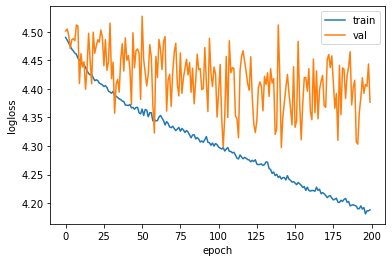

In [119]:
plt.plot(history.history['loss'], label='train');
plt.plot(history.history['val_loss'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('logloss');
plt.savefig('loss');

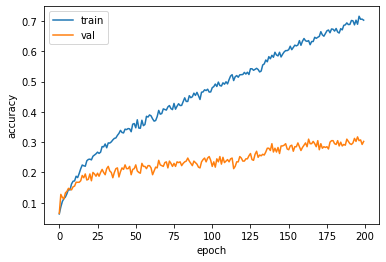

In [120]:
plt.plot(history.history['accuracy'], label='train');
plt.plot(history.history['val_accuracy'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');
plt.savefig('acc');

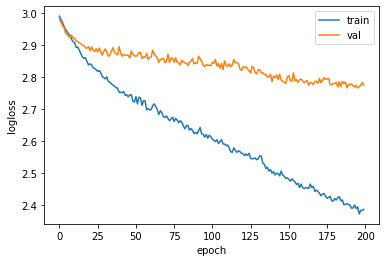

In [121]:
plt.plot(history.history['categorical_crossentropy'], label='train');
plt.plot(history.history['val_categorical_crossentropy'], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('logloss');
plt.savefig('logloss');